In [80]:
import pyro
import torch
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import datetime

plt.style.use('fivethirtyeight')

In [3]:
parameters = {
    "30-34":{
        "conception":0.16,
        "miscarriage":0.108,
        "stillbirth":0.0034,
    },
    "35-39":{
        "conception":0.11,
        "miscarriage":0.167,
        "stillbirth":0.0040,
    },
    "40-44": {
        "conception":0.06,
        "miscarriage":0.332,
        "stillbirth":0.053,
    },
}

In [56]:
def attempt(params, t=0):
    days_to_conception = pyro.distributions.Geometric(params["conception"]).sample().item() * 28
    
    if pyro.distributions.Bernoulli(params["miscarriage"]).sample().item() == 1:
        wasted_days = np.round(np.random.uniform(low=1, high=3))*28
        return attempt(params, t + days_to_conception + wasted_days)
    
    if  pyro.distributions.Bernoulli(params["stillbirth"]).sample().item() == 1:
        wasted_days = np.round(np.random.uniform(low=4, high=9))*28
        return attempt(params, t + days_to_conception + wasted_days)
    
    gestation_days = pyro.distributions.Normal(280, 16).sample().item()
    
    return t + days_to_conception + gestation_days

In [62]:
simulations=10000
results = {}
for age,params in parameters.items():
    days = []
    for _ in range(simulations):
        days.append(attempt(params))
    results[age] = days

              30-34         35-39         40-44
count  10000.000000  10000.000000  10000.000000
mean     450.468925    564.915059   1014.405982
std      186.438621    302.094772    749.461313
min      231.095963    212.554626    234.158234
25%      318.653328    353.227615    481.150520
50%      392.891968    472.289490    783.908081
75%      521.811295    680.144676   1305.444183
max     2185.023560   3563.740356   6544.645050


Text(0.5, 1.0, 'Probability of birth before a given day (CDF)')

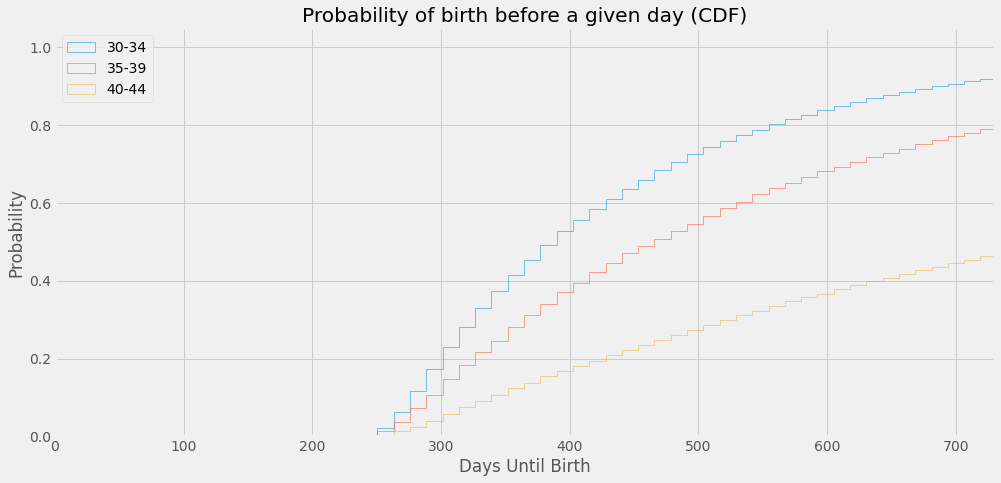

In [81]:
days_df = pd.DataFrame(results)
print(days_df.describe())
axes = days_df.plot(
    kind='hist',
    figsize=(15,7),
    bins=500,
    xlim=(0,365*2),
    cumulative=True,
    density=True,
    histtype='step',
)
axes.set_xlabel("Days Until Birth")
axes.set_ylabel("Probability")
    
axes.set_title(f"Probability of birth before a given day (CDF)")

Text(0.5, 1.0, 'Number of birth on a given day out of 10,000 simulations')

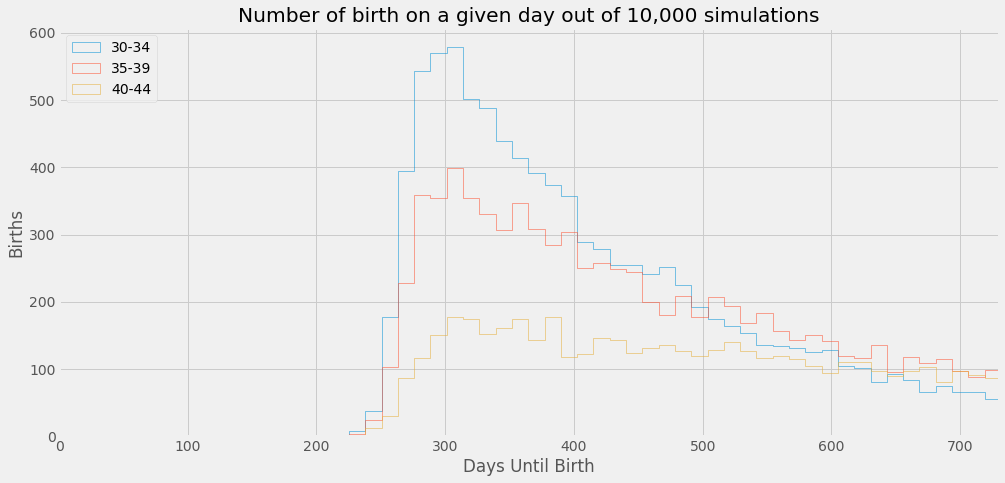

In [82]:
axes = days_df.plot(
    kind='hist',
    figsize=(15,7),
    bins=500,
    xlim=(0,365*2),
    histtype='step'
)

axes.set_xlabel("Days Until Birth")
axes.set_ylabel("Births")
    
axes.set_title(f"Number of birth on a given day out of {simulations:,} simulations")

In [83]:
ovulation = datetime.date(2020,9,1)
p25_date = ovulation + datetime.timedelta(days = days_df['30-34'].quantile(0.25))
p50_date = ovulation + datetime.timedelta(days = days_df['30-34'].quantile(0.50))
p75_date = ovulation + datetime.timedelta(days = days_df['30-34'].quantile(0.75))

print(f"25th percentile date: {p25_date}")
print(f"50th percentile date: {p50_date}")
print(f"75th percentile date: {p75_date}")

25th percentile date: 2021-07-16
50th percentile date: 2021-09-28
75th percentile date: 2022-02-04
